In [1]:
from __future__ import absolute_import, division, print_function

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras

In [3]:
import tensorflow_datasets as tfds

In [4]:
SPLIT_WEIGHTS = (8,1,1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
                    'cats_vs_dogs', split=list(splits),
                    with_info=True, as_supervised=True)

In [5]:
print(raw_train)
print(raw_train)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
get_label_name = metadata.features['label'].int2str

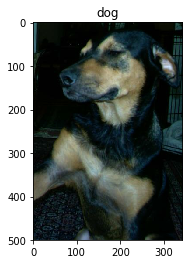

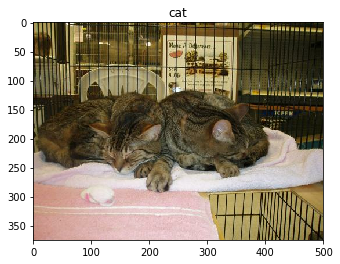

In [7]:
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [8]:
IMG_SIZE = 160 # modify the image size

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label 

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
for image_batch, label_batch in train_batches.take(1):
    pass

In [13]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [15]:
# Create a base model from MoblieNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

In [16]:
feature_batch = base_model(image_batch)

In [17]:
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
# It is important to freeze the model before adding our traninable model as it stop weights to get updated during traning 

In [19]:
base_model.trainable = False

In [20]:
# Base model summary 
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
model = tf.keras.Sequential([
    base_model, 
    global_average_layer,
    prediction_layer
])

In [24]:
base_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
len(model.trainable_variables)

2

In [27]:
num_train, num_val, num_test = (
                metadata.splits['train'].num_examples*weight/10 
                for weight in SPLIT_WEIGHTS)

In [28]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20 

In [29]:
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 8s 395ms/step - loss: 3.7237 - accuracy: 0.6359


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("intial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.72
intial accuracy: 0.64


In [31]:
history = model.fit(train_batches.repeat(),
                   epochs=initial_epochs,
                   steps_per_epoch= steps_per_epoch,
                   validation_data=validation_batches.repeat(),
                   validation_steps=validation_steps)

Epoch 1/10
581/581 [==============================] - 273s 470ms/step - loss: 1.9377 - accuracy: 0.7551 - val_loss: 0.8064 - val_accuracy: 0.9031
Epoch 2/10
581/581 [==============================] - 284s 489ms/step - loss: 1.0910 - accuracy: 0.8602 - val_loss: 0.5491 - val_accuracy: 0.9344
Epoch 3/10
581/581 [==============================] - 284s 489ms/step - loss: 0.7931 - accuracy: 0.8927 - val_loss: 0.4633 - val_accuracy: 0.9469
Epoch 4/10
581/581 [==============================] - 288s 495ms/step - loss: 0.6550 - accuracy: 0.9121 - val_loss: 0.3806 - val_accuracy: 0.9484
Epoch 5/10
581/581 [==============================] - 285s 491ms/step - loss: 0.5908 - accuracy: 0.9215 - val_loss: 0.3547 - val_accuracy: 0.9484
Epoch 6/10
581/581 [==============================] - 292s 502ms/step - loss: 0.5589 - accuracy: 0.9270 - val_loss: 0.3530 - val_accuracy: 0.9547
Epoch 7/10
581/581 [==============================] - 283s 487ms/step - loss: 0.4986 - accuracy: 0.9351 - val_loss: 0.3651 -

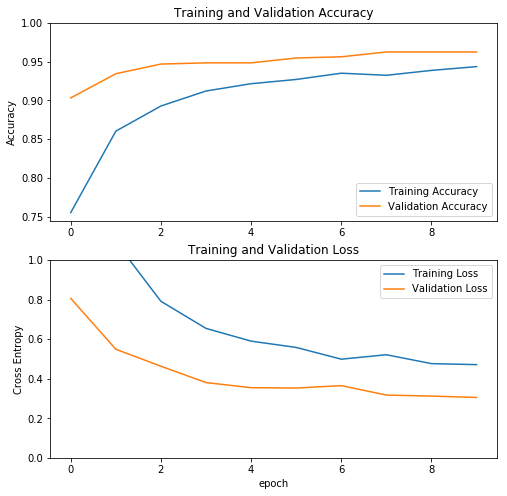

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
base_model.trainable = True

In [34]:
# Look number of layers in base model 
print("Number of layer in base model : ", len(base_model.layers))

Number of layer in base model :  155


In [35]:
# Fine tune the layers onwards 
fine_tune_at = 100 

In [36]:
# Freeze all the layers before the `fine tune at ` layer 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [39]:
len(model.trainable_variables)

58

In [40]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [41]:
history_fine = model.fit(train_batches.repeat(),
                        steps_per_epoch= steps_per_epoch,
                        epochs=total_epochs,
                        initial_epoch=initial_epochs,
                        validation_data=validation_batches.repeat(),
                        validation_steps = validation_steps)

Epoch 11/20
581/581 [==============================] - 382s 657ms/step - loss: 0.4128 - accuracy: 0.9497 - val_loss: 0.2378 - val_accuracy: 0.9750
Epoch 12/20
581/581 [==============================] - 403s 693ms/step - loss: 0.3451 - accuracy: 0.9597 - val_loss: 0.2139 - val_accuracy: 0.9766
Epoch 13/20
581/581 [==============================] - 373s 642ms/step - loss: 0.2899 - accuracy: 0.9666 - val_loss: 0.2336 - val_accuracy: 0.9781
Epoch 14/20
581/581 [==============================] - 363s 626ms/step - loss: 0.2447 - accuracy: 0.9715 - val_loss: 0.1628 - val_accuracy: 0.9797
Epoch 15/20
581/581 [==============================] - 372s 640ms/step - loss: 0.2145 - accuracy: 0.9736 - val_loss: 0.2063 - val_accuracy: 0.9781
Epoch 16/20
581/581 [==============================] - 393s 677ms/step - loss: 0.1933 - accuracy: 0.9779 - val_loss: 0.1835 - val_accuracy: 0.9797
Epoch 17/20
581/581 [==============================] - 377s 650ms/step - loss: 0.1581 - accuracy: 0.9813 - val_loss: 0

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

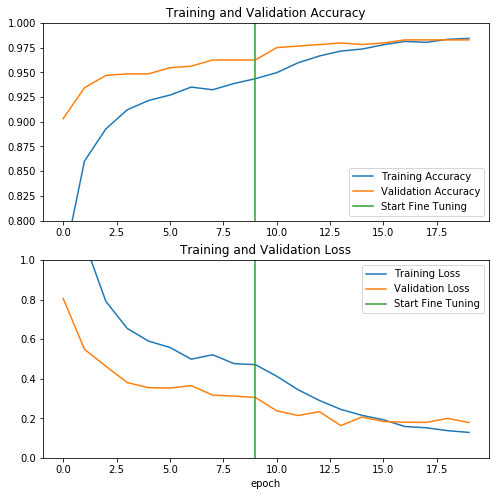

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In summary here is what we covered in this tutorial on how to do transfer learning using a pre-trained model to improve accuracy: * Using a pre-trained model for feature extraction - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training. In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs. * Fine-tuning a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.